<a href="https://colab.research.google.com/github/yendriferreira/Credit-Card-FraudML/blob/main/Base_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

files = os.listdir('/kaggle/input/creditcardfraud')
print("Files in dataset directory:", files)

# Load the CSV into a DataFrame
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

Path to dataset files: /kaggle/input/creditcardfraud
Files in dataset directory: ['creditcard.csv']


En este colab vamos a entrenar todos los modelos base sin cambios en los hiperparametros.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, average_precision_score, precision_recall_curve, roc_curve,
    classification_report
)

# Modelos tradicionales
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# One-Class y Anomaly Detection
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Balanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Supongamos que tienes tu DataFrame 'df' cargado
# X = df.drop(columns=["Class"])
# y = df["Class"]

class FraudDetectionPipeline:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.scaler = StandardScaler()
        self.X_scaled = None
        self.results = []

    def prepare_data(self):
        """Escalar los datos"""
        self.X_scaled = self.scaler.fit_transform(self.X)
        print(f" Dataset preparado: {self.X_scaled.shape[0]} transacciones")
        print(f" Fraudes: {self.y.sum()} ({self.y.mean()*100:.3f}%)")

    def run_traditional_models(self):
        """Ejecutar modelos tradicionales con balanceo"""
        print("\n" + "="*60)
        print(" MODELOS TRADICIONALES CON BALANCEO")
        print("="*60)

        # Modelos tradicionales
        models = {
            "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
            "KNN": KNeighborsClassifier(n_neighbors=5),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "MLP": MLPClassifier(max_iter=300, random_state=42),
            "SVM": CalibratedClassifierCV(LinearSVC(max_iter=1000, random_state=42))
        }

        # Técnicas de balanceo
        balancing_methods = {
            "Sin Balanceo": None,
            "Random Undersampling": RandomUnderSampler(random_state=42),
            "SMOTE": SMOTE(random_state=42)
        }

        for balance_name, sampler in balancing_methods.items():
            print(f"\n --- MÉTODO DE BALANCEO: {balance_name} ---")

            for model_name, model in models.items():
                print(f" Entrenando: {model_name}...")

                # Pipeline
                if sampler:
                    pipeline = ImbPipeline([
                        ("sampler", sampler),
                        ("classifier", model)
                    ])
                else:
                    pipeline = ImbPipeline([("classifier", model)])

                # Split
                X_train, X_test, y_train, y_test = train_test_split(
                    self.X_scaled, self.y, test_size=0.3, random_state=42, stratify=self.y
                )

                # Entrenar
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                # Probabilidades
                try:
                    y_proba = pipeline.predict_proba(X_test)[:, 1]
                except AttributeError:
                    y_proba = pipeline.decision_function(X_test)
                    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

                # Métricas
                metrics = self._calculate_metrics(y_test, y_pred, y_proba)
                metrics.update({
                    "Enfoque": "Tradicional",
                    "Balanceo": balance_name,
                    "Modelo": model_name
                })
                self.results.append(metrics)

                self._print_metrics(model_name, balance_name, metrics, y_test, y_pred)

    def run_anomaly_detection(self):
        """Ejecutar modelos de detección de anomalías"""
        print("\n" + "="*60)
        print(" MODELOS DE DETECCIÓN DE ANOMALÍAS")
        print("="*60)

        # Solo usar transacciones normales para entrenar
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y, test_size=0.3, random_state=42, stratify=self.y
        )

        # Filtrar solo transacciones normales para entrenamiento
        X_train_normal = X_train[y_train == 0]
        print(f" Entrenando solo con transacciones normales: {len(X_train_normal)}")

        # Modelos de anomaly detection
        anomaly_models = {
            "One-Class SVM (RBF)": OneClassSVM(kernel='rbf', gamma='scale', nu=0.01),
            "One-Class SVM (Linear)": OneClassSVM(kernel='linear', nu=0.01),
            "Isolation Forest": IsolationForest(contamination=0.01, random_state=42),
            "Local Outlier Factor": LocalOutlierFactor(novelty=True, contamination=0.01)
        }

        for model_name, model in anomaly_models.items():
            print(f"\n Entrenando: {model_name}...")

            # Entrenar solo con datos normales
            model.fit(X_train_normal)

            # Predecir en test set
            if hasattr(model, 'decision_function'):
                anomaly_scores = model.decision_function(X_test)
                # One-Class SVM: valores negativos = anomalías
                # Isolation Forest: valores negativos = anomalías
                y_pred_anomaly = (anomaly_scores < 0).astype(int)
                # Convertir scores a probabilidades para métricas
                y_proba = 1 / (1 + np.exp(anomaly_scores))  # Sigmoid
            else:
                # Para otros modelos que no tienen decision_function
                y_pred_anomaly = model.predict(X_test)
                y_pred_anomaly = (y_pred_anomaly == -1).astype(int)  # -1 = anomalía
                y_proba = y_pred_anomaly.astype(float)

            # Métricas
            metrics = self._calculate_metrics(y_test, y_pred_anomaly, y_proba)
            metrics.update({
                "Enfoque": "Anomaly Detection",
                "Balanceo": "N/A",
                "Modelo": model_name
            })
            self.results.append(metrics)

            self._print_metrics(model_name, "Anomaly Detection", metrics, y_test, y_pred_anomaly)

    def _calculate_metrics(self, y_true, y_pred, y_proba):
        """Calcular todas las métricas"""
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0),
            "AUC-ROC": roc_auc_score(y_true, y_proba),
            "AUPRC": average_precision_score(y_true, y_proba)
        }

    def _print_metrics(self, model_name, method, metrics, y_test, y_pred):
        """Imprimir métricas formateadas"""
        cm = confusion_matrix(y_test, y_pred)
        print(f"""
       Resultados de {model_name}:
      - Accuracy:  {metrics['Accuracy']:.4f}
      - Precision: {metrics['Precision']:.4f}
      - Recall:    {metrics['Recall']:.4f}
      - F1 Score:  {metrics['F1']:.4f}
      - AUC-ROC:   {metrics['AUC-ROC']:.4f}
      - AUPRC:     {metrics['AUPRC']:.4f}
      - Matriz de confusión:
      {cm}
        """)

    def plot_comparison(self):
        """Visualizar comparación de resultados"""
        df_results = pd.DataFrame(self.results)

        # Gráfico de comparación por AUPRC
        plt.figure(figsize=(15, 10))

        # Subplot 1: AUPRC por enfoque
        plt.subplot(2, 2, 1)
        traditional = df_results[df_results['Enfoque'] == 'Tradicional']
        anomaly = df_results[df_results['Enfoque'] == 'Anomaly Detection']

        plt.boxplot([traditional['AUPRC'], anomaly['AUPRC']],
                   labels=['Tradicional', 'Anomaly Detection'])
        plt.title('Distribución AUPRC por Enfoque')
        plt.ylabel('AUPRC')

        # Subplot 2: Top modelos por AUPRC
        plt.subplot(2, 2, 2)
        top_models = df_results.nlargest(10, 'AUPRC')
        colors = ['red' if x == 'Anomaly Detection' else 'blue' for x in top_models['Enfoque']]
        plt.barh(range(len(top_models)), top_models['AUPRC'], color=colors)
        plt.yticks(range(len(top_models)),
                  [f"{row['Modelo']}\n({row['Balanceo']})" for _, row in top_models.iterrows()])
        plt.xlabel('AUPRC')
        plt.title('Top 10 Modelos por AUPRC')

        # Subplot 3: Precision vs Recall
        plt.subplot(2, 2, 3)
        for enfoque in df_results['Enfoque'].unique():
            subset = df_results[df_results['Enfoque'] == enfoque]
            plt.scatter(subset['Recall'], subset['Precision'],
                       label=enfoque, alpha=0.7, s=50)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision vs Recall')
        plt.legend()

        # Subplot 4: F1 Score comparison
        plt.subplot(2, 2, 4)
        df_pivot = df_results.pivot_table(values='F1', index='Modelo',
                                         columns='Enfoque', aggfunc='max')
        df_pivot.plot(kind='bar', ax=plt.gca())
        plt.title('F1 Score por Modelo y Enfoque')
        plt.xticks(rotation=45)
        plt.legend()

        plt.tight_layout()
        plt.show()

        return df_results

    def get_best_models(self, top_n=5):
        """Obtener los mejores modelos según AUPRC"""
        df_results = pd.DataFrame(self.results)
        best = df_results.nlargest(top_n, 'AUPRC')[
            ['Enfoque', 'Modelo', 'Balanceo', 'AUPRC', 'Precision', 'Recall', 'F1']
        ]

        print(f"\n TOP {top_n} MODELOS POR AUPRC:")
        print("="*80)
        for i, (_, row) in enumerate(best.iterrows(), 1):
            print(f"{i}. {row['Modelo']} ({row['Enfoque']}) - Balanceo: {row['Balanceo']}")
            print(f"   AUPRC: {row['AUPRC']:.4f} | F1: {row['F1']:.4f} | "
                  f"Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f}")

        return best


 Dataset preparado: 284807 transacciones
 Fraudes: 492 (0.173%)

 MODELOS TRADICIONALES CON BALANCEO

 --- MÉTODO DE BALANCEO: Sin Balanceo ---
 Entrenando: Regresión Logística...

       Resultados de Regresión Logística:
      - Accuracy:  0.9991
      - Precision: 0.8476
      - Recall:    0.6014
      - F1 Score:  0.7036
      - AUC-ROC:   0.9575
      - AUPRC:     0.7066
      - Matriz de confusión:
      [[85279    16]
 [   59    89]]
        
 Entrenando: KNN...

       Resultados de KNN:
      - Accuracy:  0.9994
      - Precision: 0.9160
      - Recall:    0.7365
      - F1 Score:  0.8165
      - AUC-ROC:   0.9188
      - AUPRC:     0.8011
      - Matriz de confusión:
      [[85285    10]
 [   39   109]]
        
 Entrenando: Random Forest...

       Resultados de Random Forest:
      - Accuracy:  0.9995
      - Precision: 0.9573
      - Recall:    0.7568
      - F1 Score:  0.8453
      - AUC-ROC:   0.9307
      - AUPRC:     0.8227
      - Matriz de confusión:
      [[85290   

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



       Resultados de MLP:
      - Accuracy:  0.9703
      - Precision: 0.0493
      - Recall:    0.8851
      - F1 Score:  0.0935
      - AUC-ROC:   0.9722
      - AUPRC:     0.6180
      - Matriz de confusión:
      [[82771  2524]
 [   17   131]]
        
 Entrenando: SVM...

       Resultados de SVM:
      - Accuracy:  0.9984
      - Precision: 0.5200
      - Recall:    0.7905
      - F1 Score:  0.6273
      - AUC-ROC:   0.9724
      - AUPRC:     0.6791
      - Matriz de confusión:
      [[85187   108]
 [   31   117]]
        

 --- MÉTODO DE BALANCEO: SMOTE ---
 Entrenando: Regresión Logística...

       Resultados de Regresión Logística:
      - Accuracy:  0.9776
      - Precision: 0.0643
      - Recall:    0.8784
      - F1 Score:  0.1198
      - AUC-ROC:   0.9670
      - AUPRC:     0.7080
      - Matriz de confusión:
      [[83403  1892]
 [   18   130]]
        
 Entrenando: KNN...

       Resultados de KNN:
      - Accuracy:  0.9981
      - Precision: 0.4767
      - Recall:    

/tmp/ipython-input-2-3087732151.py:207: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([traditional['AUPRC'], anomaly['AUPRC']],


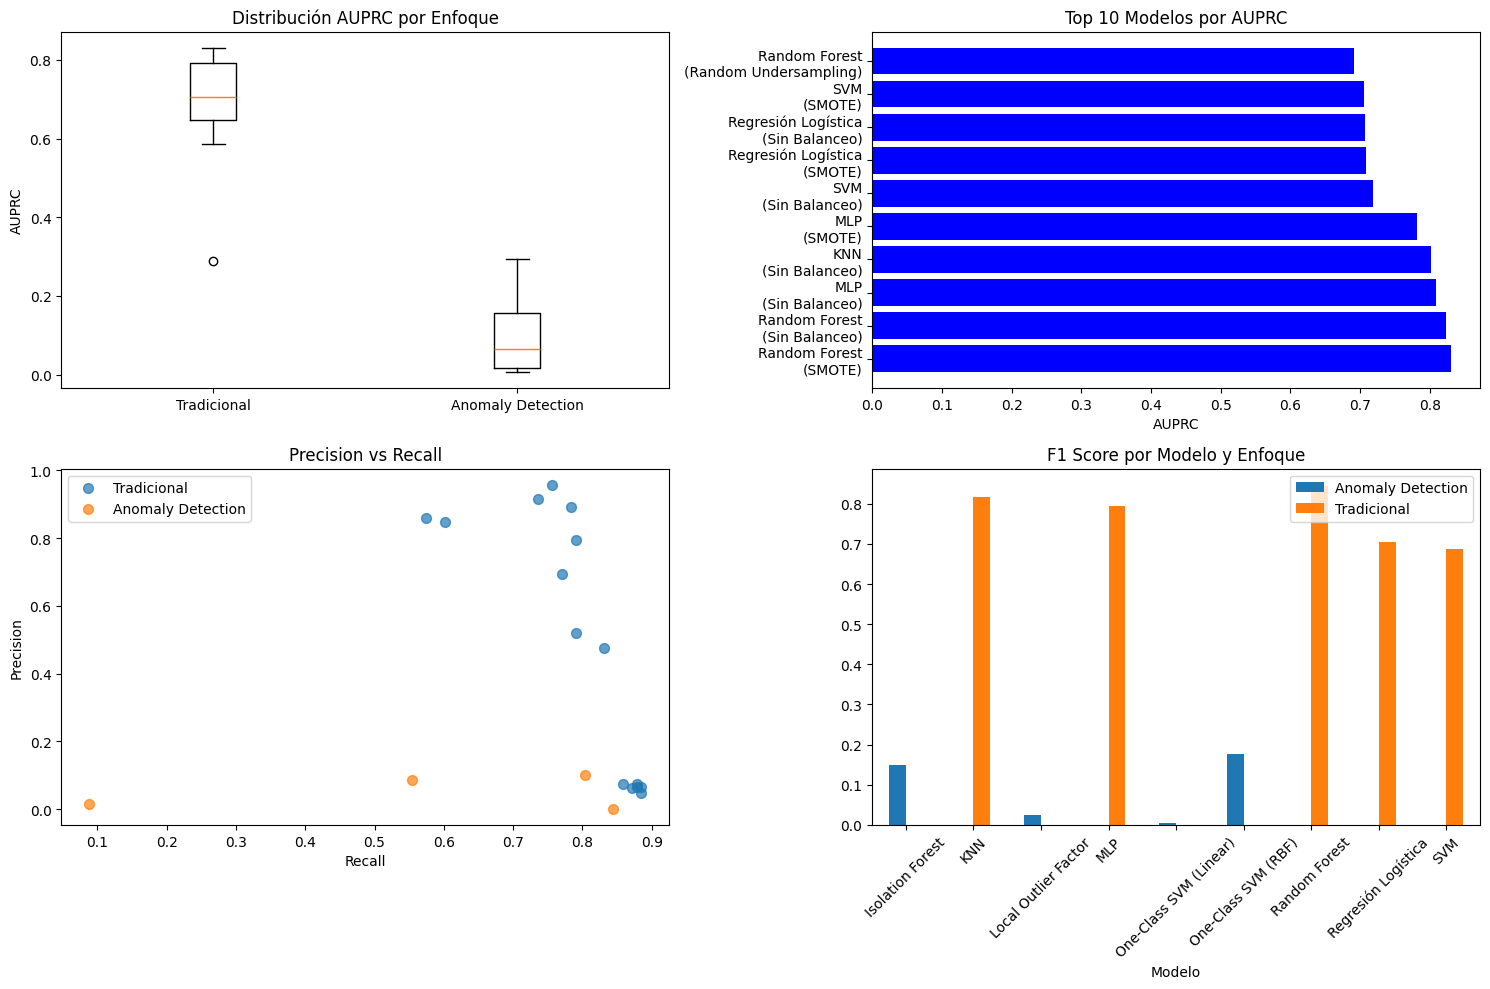

In [3]:


X = df.drop(columns=['Class'])
y = df['Class']

# Ejecutar pipeline completo
pipeline = FraudDetectionPipeline(X, y)
pipeline.prepare_data()
pipeline.run_traditional_models()
pipeline.run_anomaly_detection()
results_df = pipeline.plot_comparison()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Recreando el DataFrame de resultados a partir de tu salida
data = [
    {'Enfoque': 'Tradicional', 'Balanceo': 'Sin Balanceo', 'Modelo': 'Regresión Logística', 'Accuracy': 0.9991, 'Precision': 0.8476, 'Recall': 0.6014, 'F1': 0.7036, 'AUC-ROC': 0.9575, 'AUPRC': 0.7066},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Sin Balanceo', 'Modelo': 'KNN', 'Accuracy': 0.9994, 'Precision': 0.9160, 'Recall': 0.7365, 'F1': 0.8165, 'AUC-ROC': 0.9188, 'AUPRC': 0.8011},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Sin Balanceo', 'Modelo': 'Random Forest', 'Accuracy': 0.9995, 'Precision': 0.9573, 'Recall': 0.7568, 'F1': 0.8453, 'AUC-ROC': 0.9307, 'AUPRC': 0.8227},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Sin Balanceo', 'Modelo': 'MLP', 'Accuracy': 0.9993, 'Precision': 0.7959, 'Recall': 0.7905, 'F1': 0.7932, 'AUC-ROC': 0.9564, 'AUPRC': 0.8093},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Sin Balanceo', 'Modelo': 'SVM', 'Accuracy': 0.9991, 'Precision': 0.8586, 'Recall': 0.5743, 'F1': 0.6883, 'AUC-ROC': 0.9460, 'AUPRC': 0.7191},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Random Undersampling', 'Modelo': 'Regresión Logística', 'Accuracy': 0.9775, 'Precision': 0.0642, 'Recall': 0.8851, 'F1': 0.1197, 'AUC-ROC': 0.9714, 'AUPRC': 0.5863},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Random Undersampling', 'Modelo': 'KNN', 'Accuracy': 0.9811, 'Precision': 0.0738, 'Recall': 0.8581, 'F1': 0.1359, 'AUC-ROC': 0.9523, 'AUPRC': 0.2883},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Random Undersampling', 'Modelo': 'Random Forest', 'Accuracy': 0.9805, 'Precision': 0.0731, 'Recall': 0.8784, 'F1': 0.1350, 'AUC-ROC': 0.9728, 'AUPRC': 0.6915},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Random Undersampling', 'Modelo': 'MLP', 'Accuracy': 0.9703, 'Precision': 0.0493, 'Recall': 0.8851, 'F1': 0.0935, 'AUC-ROC': 0.9722, 'AUPRC': 0.6180},
    {'Enfoque': 'Tradicional', 'Balanceo': 'Random Undersampling', 'Modelo': 'SVM', 'Accuracy': 0.9984, 'Precision': 0.5200, 'Recall': 0.7905, 'F1': 0.6273, 'AUC-ROC': 0.9724, 'AUPRC': 0.6791},
    {'Enfoque': 'Tradicional', 'Balanceo': 'SMOTE', 'Modelo': 'Regresión Logística', 'Accuracy': 0.9776, 'Precision': 0.0643, 'Recall': 0.8784, 'F1': 0.1198, 'AUC-ROC': 0.9670, 'AUPRC': 0.7080},
    {'Enfoque': 'Tradicional', 'Balanceo': 'SMOTE', 'Modelo': 'KNN', 'Accuracy': 0.9981, 'Precision': 0.4767, 'Recall': 0.8311, 'F1': 0.6059, 'AUC-ROC': 0.9218, 'AUPRC': 0.6099},
    {'Enfoque': 'Tradicional', 'Balanceo': 'SMOTE', 'Modelo': 'Random Forest', 'Accuracy': 0.9995, 'Precision': 0.8923, 'Recall': 0.7838, 'F1': 0.8345, 'AUC-ROC': 0.9625, 'AUPRC': 0.8304},
    {'Enfoque': 'Tradicional', 'Balanceo': 'SMOTE', 'Modelo': 'MLP', 'Accuracy': 0.9990, 'Precision': 0.6951, 'Recall': 0.7703, 'F1': 0.7308, 'AUC-ROC': 0.9406, 'AUPRC': 0.7819},
    {'Enfoque': 'Tradicional', 'Balanceo': 'SMOTE', 'Modelo': 'SVM', 'Accuracy': 0.9767, 'Precision': 0.0614, 'Recall': 0.8716, 'F1': 0.1148, 'AUC-ROC': 0.9668, 'AUPRC': 0.7053},
    {'Enfoque': 'Anomaly Detection', 'Balanceo': 'N/A', 'Modelo': 'One-Class SVM (RBF)', 'Accuracy': 0.9871, 'Precision': 0.0997, 'Recall': 0.8041, 'F1': 0.1773, 'AUC-ROC': 0.9292, 'AUPRC': 0.2937},
    {'Enfoque': 'Anomaly Detection', 'Balanceo': 'N/A', 'Modelo': 'One-Class SVM (Linear)', 'Accuracy': 0.1636, 'Precision': 0.0017, 'Recall': 0.8446, 'F1': 0.0035, 'AUC-ROC': 0.5551, 'AUPRC': 0.0206},
    {'Enfoque': 'Anomaly Detection', 'Balanceo': 'N/A', 'Modelo': 'Isolation Forest', 'Accuracy': 0.9891, 'Precision': 0.0869, 'Recall': 0.5541, 'F1': 0.1502, 'AUC-ROC': 0.9471, 'AUPRC': 0.1099},
    {'Enfoque': 'Anomaly Detection', 'Balanceo': 'N/A', 'Modelo': 'Local Outlier Factor', 'Accuracy': 0.9884, 'Precision': 0.0150, 'Recall': 0.0878, 'F1': 0.0256, 'AUC-ROC': 0.7412, 'AUPRC': 0.0070}
]
results_df = pd.DataFrame(data)

# Crear una columna combinada para facilitar el etiquetado en los gráficos
results_df['Etiqueta'] = results_df['Modelo'] + ' (' + results_df['Balanceo'] + ')'

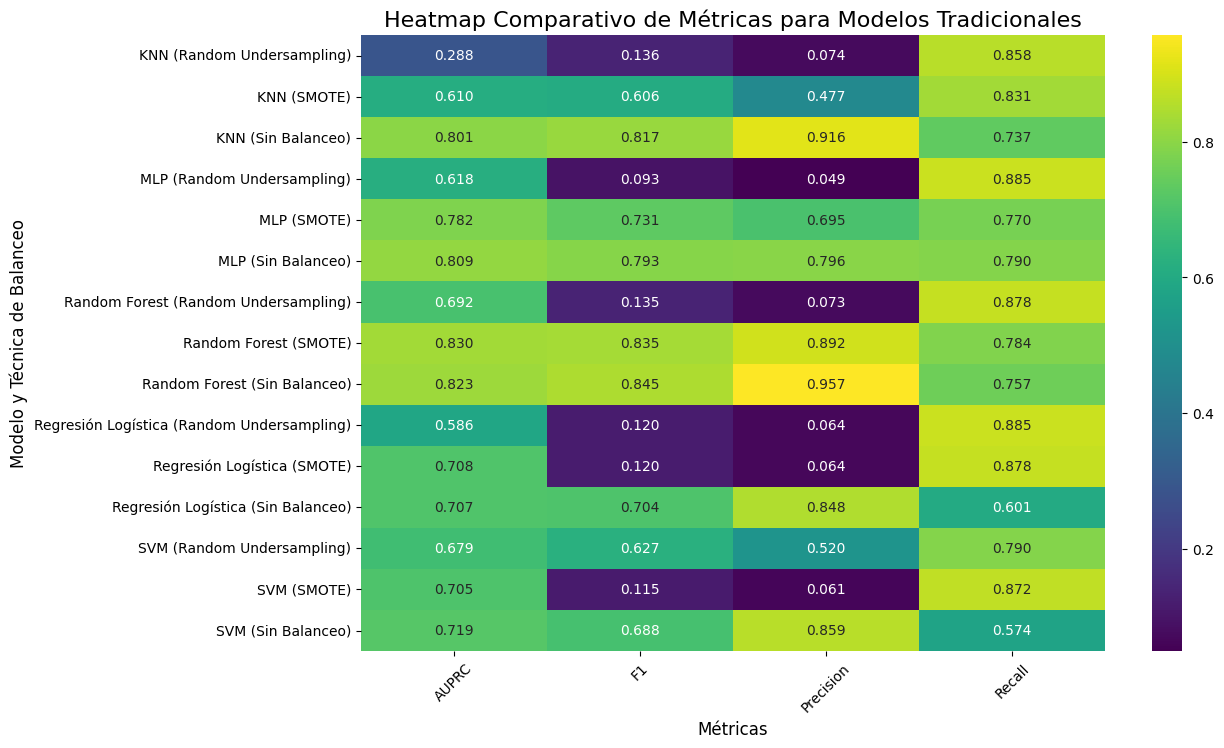

In [5]:
# Seleccionar solo los modelos tradicionales para una comparación más clara del balanceo
df_tradicional = results_df[results_df['Enfoque'] == 'Tradicional']

# Pivotar la tabla para el heatmap
pivot_df = df_tradicional.pivot_table(
    index='Etiqueta',
    values=['AUPRC', 'F1', 'Recall', 'Precision']
)

# Graficar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".3f")
plt.title('Heatmap Comparativo de Métricas para Modelos Tradicionales', fontsize=16)
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Modelo y Técnica de Balanceo', fontsize=12)
plt.xticks(rotation=45)
plt.show()

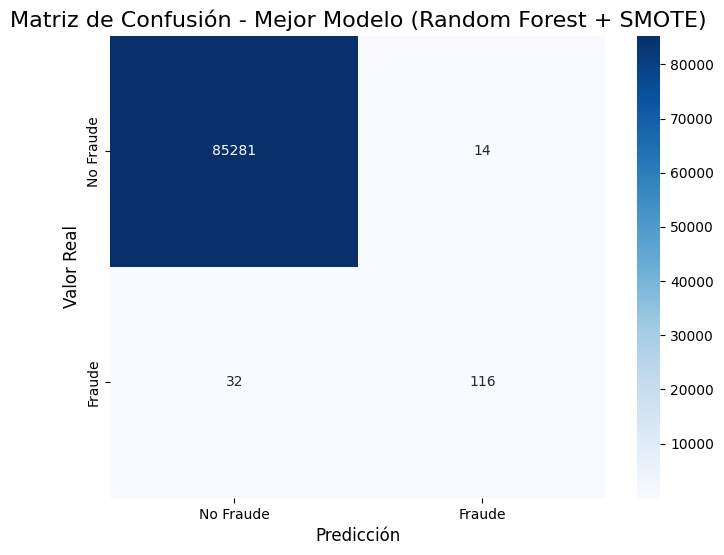

In [6]:
# Mejor modelo según tu salida: Random Forest con SMOTE
# Matriz de confusión: [[85281, 14], [32, 116]]
cm_best_model = np.array([[85281, 14], [32, 116]])
labels = ['No Fraude', 'Fraude']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - Mejor Modelo (Random Forest + SMOTE)', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()